#  Vision Transformer (VIT) for image classification

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Libraries needed

In [ ]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator,load_img
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Layer as L
from tensorflow.keras import Sequential,Model
from tensorflow.keras.layers import Normalization, Resizing, RandomRotation, RandomZoom ,Dense
from tensorflow.keras.layers import Input, LayerNormalization, MultiHeadAttention, Add, Flatten, Dropout ,Embedding
import warnings
warnings.filterwarnings("ignore")

## Call wildlife Dataset contain 4 classes

* Deer
* Coyote
*	Raccoon
*	eagle



### Call the dataset and define K-Fold Cross Validation

In [ ]:
def DataSet_(our_path,num_folds =2):
  
  data = pd.read_csv(our_path)
  df = pd.DataFrame({'Image':data['image'] , 'Class':data['Class'].astype('string')}) 
  df = df.iloc[np.random.permutation(len(df))]  # Random Rows in dataframe
  Kfold = KFold(n_splits = num_folds, shuffle = True)
  return df,Kfold

df , Kfold = DataSet_(our_path = "/content/drive/MyDrive/Vision transformer/Vision_transformer.csv")  

###Data Agumentation

In [ ]:
data_Generator = ImageDataGenerator(rescale=1./255,rotation_range=20, zoom_range=.2)

## Model Architecture
![image](https://viso.ai/wp-content/uploads/2021/09/vision-transformer-vit.png) 

# First Step Split image into Patches

In [ ]:
class Patches(L):
    def __init__(self, PS):
        self.patch_size = PS
        super(Patches, self).__init__()

    def call(self, IMG):
        input_shape = tf.shape(IMG)[0]
        patches    = tf.image.extract_patches( images = IMG, padding= "VALID",
            rates  = [1, 1, 1, 1], sizes  = [1, self.patch_size, self.patch_size, 1],
            strides= [1, self.patch_size, self.patch_size, 1],
        )
        patch_dims = patches.shape[-1]
        patches    = tf.reshape(patches, [input_shape, -1, patch_dims])
        return patches

# Second Step PatchEncoder Layer 

In [ ]:
class PatchEncoder(L):
    def __init__(self, n_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = n_patches
        self.projection  = Dense(units = projection_dim)
        self.position_embedding = Embedding(input_dim = n_patches, output_dim = projection_dim)


    def call(self, patch):
        positions = tf.range(start=0, limit = self.num_patches, delta=1)
        encoded   = self.projection(patch) + self.position_embedding(positions)
        return encoded




```
```

#Third Step Multilayer Perceptron

In [ ]:
def MLP(input_, hiddens, dropout_rate=0.1):
    for units in hiddens:
        input_ = Dense(units, activation=tf.nn.gelu)(input_) #GAUSSIAN ERROR LINEAR UNIT Function
        input_ = Dropout(dropout_rate)(input_)
    return input_

## Build The Model


In [ ]:
def Model_vit():
    ##############################################
    input_shape = (32, 32, 3)
    image_size = 32
    patch_size = 6  # Size of the patches to be extract from the input images
    num_patches = (image_size // patch_size) ** 2   
    projection_dim = 64
    NUM_LayerEncoding = 8
    Epslion_  = 1e-6    #0.000001
    num_heads = 4
    transformer_units = [projection_dim * 2, projection_dim,]  # Size of the transformer layers
    mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier       
    ##############################################

    inputs  = Input(shape = input_shape)        # input Layer
    patches = Patches(patch_size)(inputs)       # Split images into Patches
    pathes_encode = PatchEncoder(num_patches, projection_dim)(patches) # Encode image into projection_dim 
    
    
    for i in range(0,NUM_LayerEncoding):  # the Transformer block.

        X1 = LayerNormalization(epsilon=Epslion_)(pathes_encode)
        Attention_layer = MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(X1, X1)
        X2 = Add()([Attention_layer, pathes_encode])
        X3 = LayerNormalization(epsilon=Epslion_)(X2)
        X3 = MLP(X3, hiddens=transformer_units) #??
        pathes_encode = Add()([X3, X2])

    
    X = LayerNormalization(epsilon=Epslion_)(pathes_encode)
    X = Flatten()(X)
    X = Dropout(0.5)(X)
   
    X = MLP(X, hiddens=mlp_head_units, dropout_rate=0.5)
    X = Dense(4)(X)
    model = Model(inputs=inputs, outputs=X)
    return model


## Train and Evaluation Model for every K in Fold Cross Validation

In [ ]:
learning_rate = 0.01
batch_size    = 256
#K-fold Cross Validation model evaluation
fold_no = 1 
for train, test in Kfold.split(df):
  model     = Model_vit() 
  optimizer = keras.optimizers.Adam(learning_rate = learning_rate)
  model.compile( optimizer=optimizer, loss= keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 metrics= [keras.metrics.SparseCategoricalAccuracy(name="accuracy") ,
                           keras.metrics.SparseTopKCategoricalAccuracy(3,name = "top-3-accuracy")])
  Train_Data = df.iloc[train]
  Test_Data  = df.iloc[test]
  Train_gen  = data_Generator.flow_from_dataframe(Train_Data ,"/content/drive/MyDrive/Vision transformer/Dataset"  , x_col='Image', y_col='Class', target_size= (32,32) , class_mode="sparse" , batch_size= batch_size)
  Test_gen   = data_Generator.flow_from_dataframe(Test_Data  ,"/content/drive/MyDrive/Vision transformer/Dataset"  , x_col='Image', y_col='Class', target_size= (32,32) , class_mode="sparse" , batch_size= batch_size)
  history    = model.fit(Train_gen, batch_size = batch_size ,epochs = 18)
  Acc_       = model.evaluate(Test_gen)
  print('Score at Flod {:d}\n  Accuracy: {:0.2f}\n  Loss: {:0.2f}'.format(fold_no,Acc_[1],Acc_[0]))
  
  # Increase fold number
  fold_no = fold_no + 1


Found 979 validated image filenames belonging to 4 classes.
Found 995 validated image filenames belonging to 4 classes.
Epoch 1/18
4/4 [==============================] - 42s 8s/step - loss: 171.4744 - accuracy: 0.2431 - top-3-accuracy: 0.7967
Epoch 2/18
4/4 [==============================] - 31s 8s/step - loss: 135.9550 - accuracy: 0.2543 - top-3-accuracy: 0.7416
Epoch 3/18
4/4 [==============================] - 31s 8s/step - loss: 16.2347 - accuracy: 0.2360 - top-3-accuracy: 0.6854
Epoch 4/18
4/4 [==============================] - 30s 7s/step - loss: 4.2958 - accuracy: 0.2737 - top-3-accuracy: 0.7712
Epoch 5/18
4/4 [==============================] - 30s 7s/step - loss: 1.5431 - accuracy: 0.2625 - top-3-accuracy: 0.7426
Epoch 6/18
4/4 [==============================] - 30s 7s/step - loss: 1.4028 - accuracy: 0.3136 - top-3-accuracy: 0.7416
Epoch 7/18
4/4 [==============================] - 31s 7s/step - loss: 1.3851 - accuracy: 0.3350 - top-3-accuracy: 0.7385
Epoch 8/18
4/4 [============

# Test the Model

In [ ]:
predict = model.predict(Test_gen)
test_df = np.argmax(predict, axis=-1)

0
This is Deer


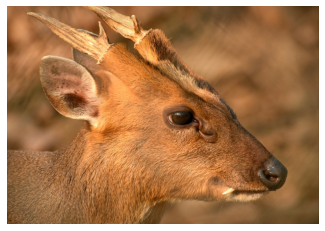

In [ ]:
predict=model.predict(Test_gen)
test_df=np.argmax(predict,axis=1)
i=np.random.choice(len(test_df))
img = Test_gen.filepaths[i]
img = load_img(img)
plt.imshow(img)
plt.axis("off")
print(test_df[i] )
if test_df[i] == 0:
  print('This is Deer')
elif test_df[i] == 1:  
  print('This is Coyote')
elif test_df[i] == 2:
  print('This is Raccoon')
else:
  print('This is eagle')    

1
This is Coyote


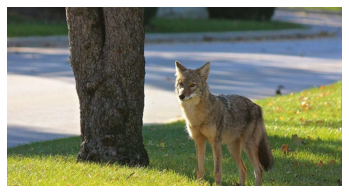

In [ ]:
predict=model.predict(Test_gen)
test_df=np.argmax(predict,axis=1)
i=np.random.choice(len(test_df))
img = Test_gen.filepaths[i]
img = load_img(img)
plt.imshow(img)
plt.axis("off")
print(test_df[i] )
if test_df[i] == 0:
  print('This is Deer')
elif test_df[i] == 1:  
  print('This is Coyote')
elif test_df[i] == 2:
  print('This is Raccoon')
else:
  print('This is eagle')    

3
This is eagle


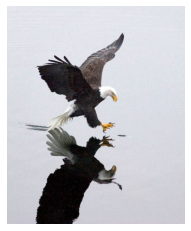

In [ ]:
predict=model.predict(Test_gen)
test_df=np.argmax(predict,axis=1)
i=np.random.choice(len(test_df))
img = Test_gen.filepaths[i]
img = load_img(img)
plt.imshow(img)
plt.axis("off")
print(test_df[i] )
if test_df[i] == 0:
  print('This is Deer')
elif test_df[i] == 1:  
  print('This is Coyote')
elif test_df[i] == 2:
  print('This is Raccoon')
else:
  print('This is eagle')  